In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import threshold_img
from nilearn.glm import threshold_stats_img

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
from nilearn import plotting, datasets, surface

# for plotting slices
mni152_template = datasets.load_mni152_template(resolution=1)
# for plotting on surface
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [3]:
task_label = 'tonecat'
contrast_label = 'sound'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'

# define data directories
bidsroot = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                        'FLT/', 'data_denoised',
                       )
nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')

# define first-level directory where group-level inputs will be pulled from
l1_dir = os.path.join(nilearn_dir, 'level-1_fwhm-%.02f'%fwhm)

# create output directory
group_out_dir = os.path.join(nilearn_dir, 'group_fwhm-%.02f'%fwhm)
if not os.path.exists(group_out_dir):
        os.makedirs(group_out_dir)

# Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [4]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27',
               'sub-FLT07', # bad QA 11/14/23
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [5]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT08   23   F      Mandarin  2005.0
6       sub-FLT09   30   F  non-Mandarin  3002.0
7       sub-FLT10   23   F      Mandarin  2006.0
8       sub-FLT11   20   F  non-Mandarin  1005.0
9       sub-FLT12   20   F  non-Mandarin  3004.0
10      sub-FLT13   23   F  non-Mandarin  3005.0
11      sub-FLT14   23   M  non-Mandarin  3006.0
12      sub-FLT15   22   M      Mandarin  2010.0
13      sub-FLT17   29   F      Mandarin     NaN
14      sub-FLT18   24   M      Mandarin  2016.0
15      sub-FLT19   24   M      Mandarin  2018.0
16      sub-FLT20   26   F  non-Mandarin  3008.0
17      sub-FLT21   21   M      Mandarin  2011.0
18      sub-FLT22   41   F      Mandarin  2017.0
19      sub-FLT23   

In [6]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [7]:
print(sub_list_mand)

['sub-FLT03', 'sub-FLT05', 'sub-FLT08', 'sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT19', 'sub-FLT21', 'sub-FLT22', 'sub-FLT23', 'sub-FLT24', 'sub-FLT26']


In [8]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25', 'sub-FLT28', 'sub-FLT30']


# TEST: between-runs analysis

### Mandarin-speaking group:

#### Get files

In [9]:
# get the beta map for the contrast of interest for each subject
fnames_early_mand = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/earlythird/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]
fnames_late_mand = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/latethird/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]

# note – these don't get used currently. the next cell is used instead. if you'd rather use this, then you need to combine the lists in an alternating fashion

In [10]:
# get the first two beta maps for each subject, corresponding to 'earlythird' and 'latethird'
fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/*third/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0:2] for sub_id in sub_list_mand]

# since the previous line creates a list of lists of strings (filenames), here we flatten it into a single list of strings (filenames)
flat_list_mand = [item for sublist in fnames_mand for item in sublist]
print(flat_list_mand)

['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/grouped_runs/earlythird/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/grouped_runs/latethird/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/grouped_runs/earlythird/sub-FLT05_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/grouped_runs/latethird/sub-FLT05_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228

In [11]:
# since our file lists are alternating early–late, our first column is alternating +/- 0.5
split_list = [x%2-0.5 for x in range(2*len(sub_list_mand))]
split_df = pd.DataFrame({'split':split_list})

# now we create a column for each participant, with 1s where their two files are
mand_sub_split_dict = {}
for sx, sub in enumerate(sub_list_mand):
    sub_ind_list = np.zeros(2*len(sub_list_mand))
    sub_ind_list[2*sx:2*sx+2] = 1
    
    mand_sub_split_dict[sub] = sub_ind_list

# turn it into a dataframe
mand_sub_split_df = pd.DataFrame(mand_sub_split_dict)

# combine the "split" column dataframe with the subject column dataframe
mand_split_df = pd.concat([split_df, mand_sub_split_df], axis=1)

In [12]:
mand_split_df

split  sub-FLT03  sub-FLT05  sub-FLT08  sub-FLT10  sub-FLT15  sub-FLT17  \
0    -0.5        1.0        0.0        0.0        0.0        0.0        0.0   
1     0.5        1.0        0.0        0.0        0.0        0.0        0.0   
2    -0.5        0.0        1.0        0.0        0.0        0.0        0.0   
3     0.5        0.0        1.0        0.0        0.0        0.0        0.0   
4    -0.5        0.0        0.0        1.0        0.0        0.0        0.0   
5     0.5        0.0        0.0        1.0        0.0        0.0        0.0   
6    -0.5        0.0        0.0        0.0        1.0        0.0        0.0   
7     0.5        0.0        0.0        0.0        1.0        0.0        0.0   
8    -0.5        0.0        0.0        0.0        0.0        1.0        0.0   
9     0.5        0.0        0.0        0.0        0.0        1.0        0.0   
10   -0.5        0.0        0.0        0.0        0.0        0.0        1.0   
11    0.5        0.0        0.0        0.0        0.0        0.0        1.0   
12   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
13    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
14   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
15    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
16   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
17    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
18   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
19    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
20   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
21    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
22   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
23    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
24   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
25    0.5        0.0        0.0        0.0        0.0        0.0        0.0   

    sub-FLT18  sub-FLT19  sub-FLT21  sub-FLT22  sub-FLT23  sub-FLT24  \
0         0.0        0.0        0.0        0.0        0.0        0.0   
1         0.0        0.0        0.0        0.0        0.0        0.0   
2         0.0        0.0        0.0        0.0        0.0        0.0   
3         0.0        0.0        0.0        0.0        0.0        0.0   
4         0.0        0.0        0.0        0.0        0.0        0.0   
5         0.0        0.0        0.0        0.0        0.0        0.0   
6         0.0        0.0        0.0        0.0        0.0        0.0   
7         0.0        0.0        0.0        0.0        0.0        0.0   
8         0.0        0.0        0.0        0.0        0.0        0.0   
9         0.0        0.0        0.0        0.0        0.0        0.0   
10        0.0        0.0        0.0        0.0        0.0        0.0   
11        0.0        0.0        0.0        0.0        0.0        0.0   
12        1.0        0.0        0.0        0.0        0.0        0.0   
13        1.0        0.0        0.0        0.0        0.0        0.0   
14        0.0        1.0        0.0        0.0        0.0        0.0   
15        0.0        1.0        0.0        0.0        0.0        0.0   
16        0.0        0.0        1.0        0.0        0.0        0.0   
17        0.0        0.0        1.0        0.0        0.0        0.0   
18        0.0        0.0        0.0        1.0        0.0        0.0   
19        0.0        0.0        0.0        1.0        0.0        0.0   
20        0.0        0.0        0.0        0.0        1.0        0.0   
21        0.0        0.0        0.0        0.0        1.0        0.0   
22        0.0        0.0        0.0        0.0        0.0        1.0   
23        0.0        0.0        0.0        0.0        0.0        1.0   
24        0.0        0.0        0.0        0.0        0.0        0.0  

#### Using combined GLM, with contrast isolating Mandarin group

In [13]:
# use early-vs-late as the contrast; all subject columns are 0
contrast_array = np.concatenate([[1,], np.zeros(len(sub_list_mand))])
print(contrast_array)           

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# create a model object
second_level_model = SecondLevelModel().fit(flat_list_mand, design_matrix=mand_split_df)

# fit the model with our contrast of interest
z_map = second_level_model.compute_contrast(second_level_contrast=contrast_array, output_type='z_score')

In [15]:
# threshold the second-level stats image
alpha = 0.05
cthresh = 10
cluster_correct = None #'fdr'

thresholded_map, zthresh = threshold_stats_img(
                            z_map,
                            alpha=alpha,
                            height_control=cluster_correct,
                            cluster_threshold=cthresh,
                            two_sided=True,
                        )

In [16]:
plot_title = ('Mandarin-speaking group (n=%d)\n'
              'early vs. late \n'
              '%s > baseline FDR-corrected z map \n'
              'p < %.02f, clusters > %d voxels'%(len(sub_list_mand), contrast_label, alpha, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


The None=0.05 threshold is 3


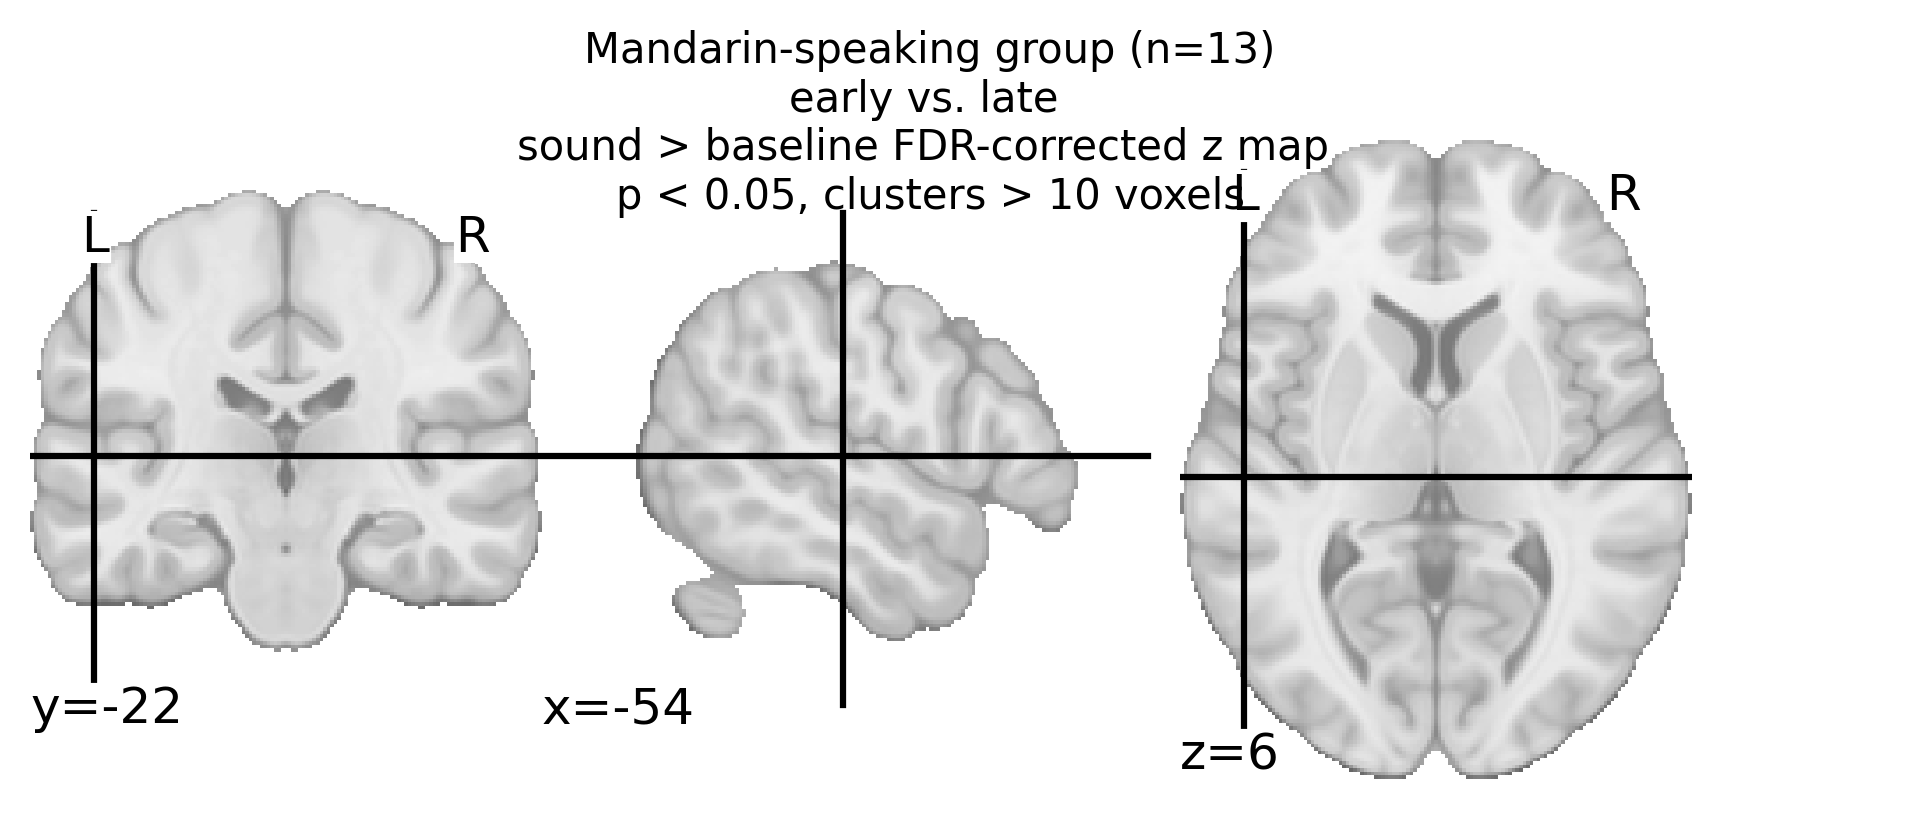

In [17]:
fig, ax = plt.subplots(figsize=(8,3), dpi=300)

plotting.plot_stat_map(
    thresholded_map, 
    threshold=zthresh,
    bg_img=mni152_template,
    black_bg=False,
    cut_coords=[-54, -22, 6],
    #display_mode='mosaic',
    #title=plot_title,
    axes=ax)
fig.suptitle(plot_title, fontsize=10);
print('The %s=%.3g threshold is %.3g' %(cluster_correct, alpha, zthresh))
#fig.savefig(os.path.join(group_out_dir,
#                     'group-Mand_space-{}_contrast-{}_view-ortho.png'.format(space_label, contrast_label)))

Interactive viewer:

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



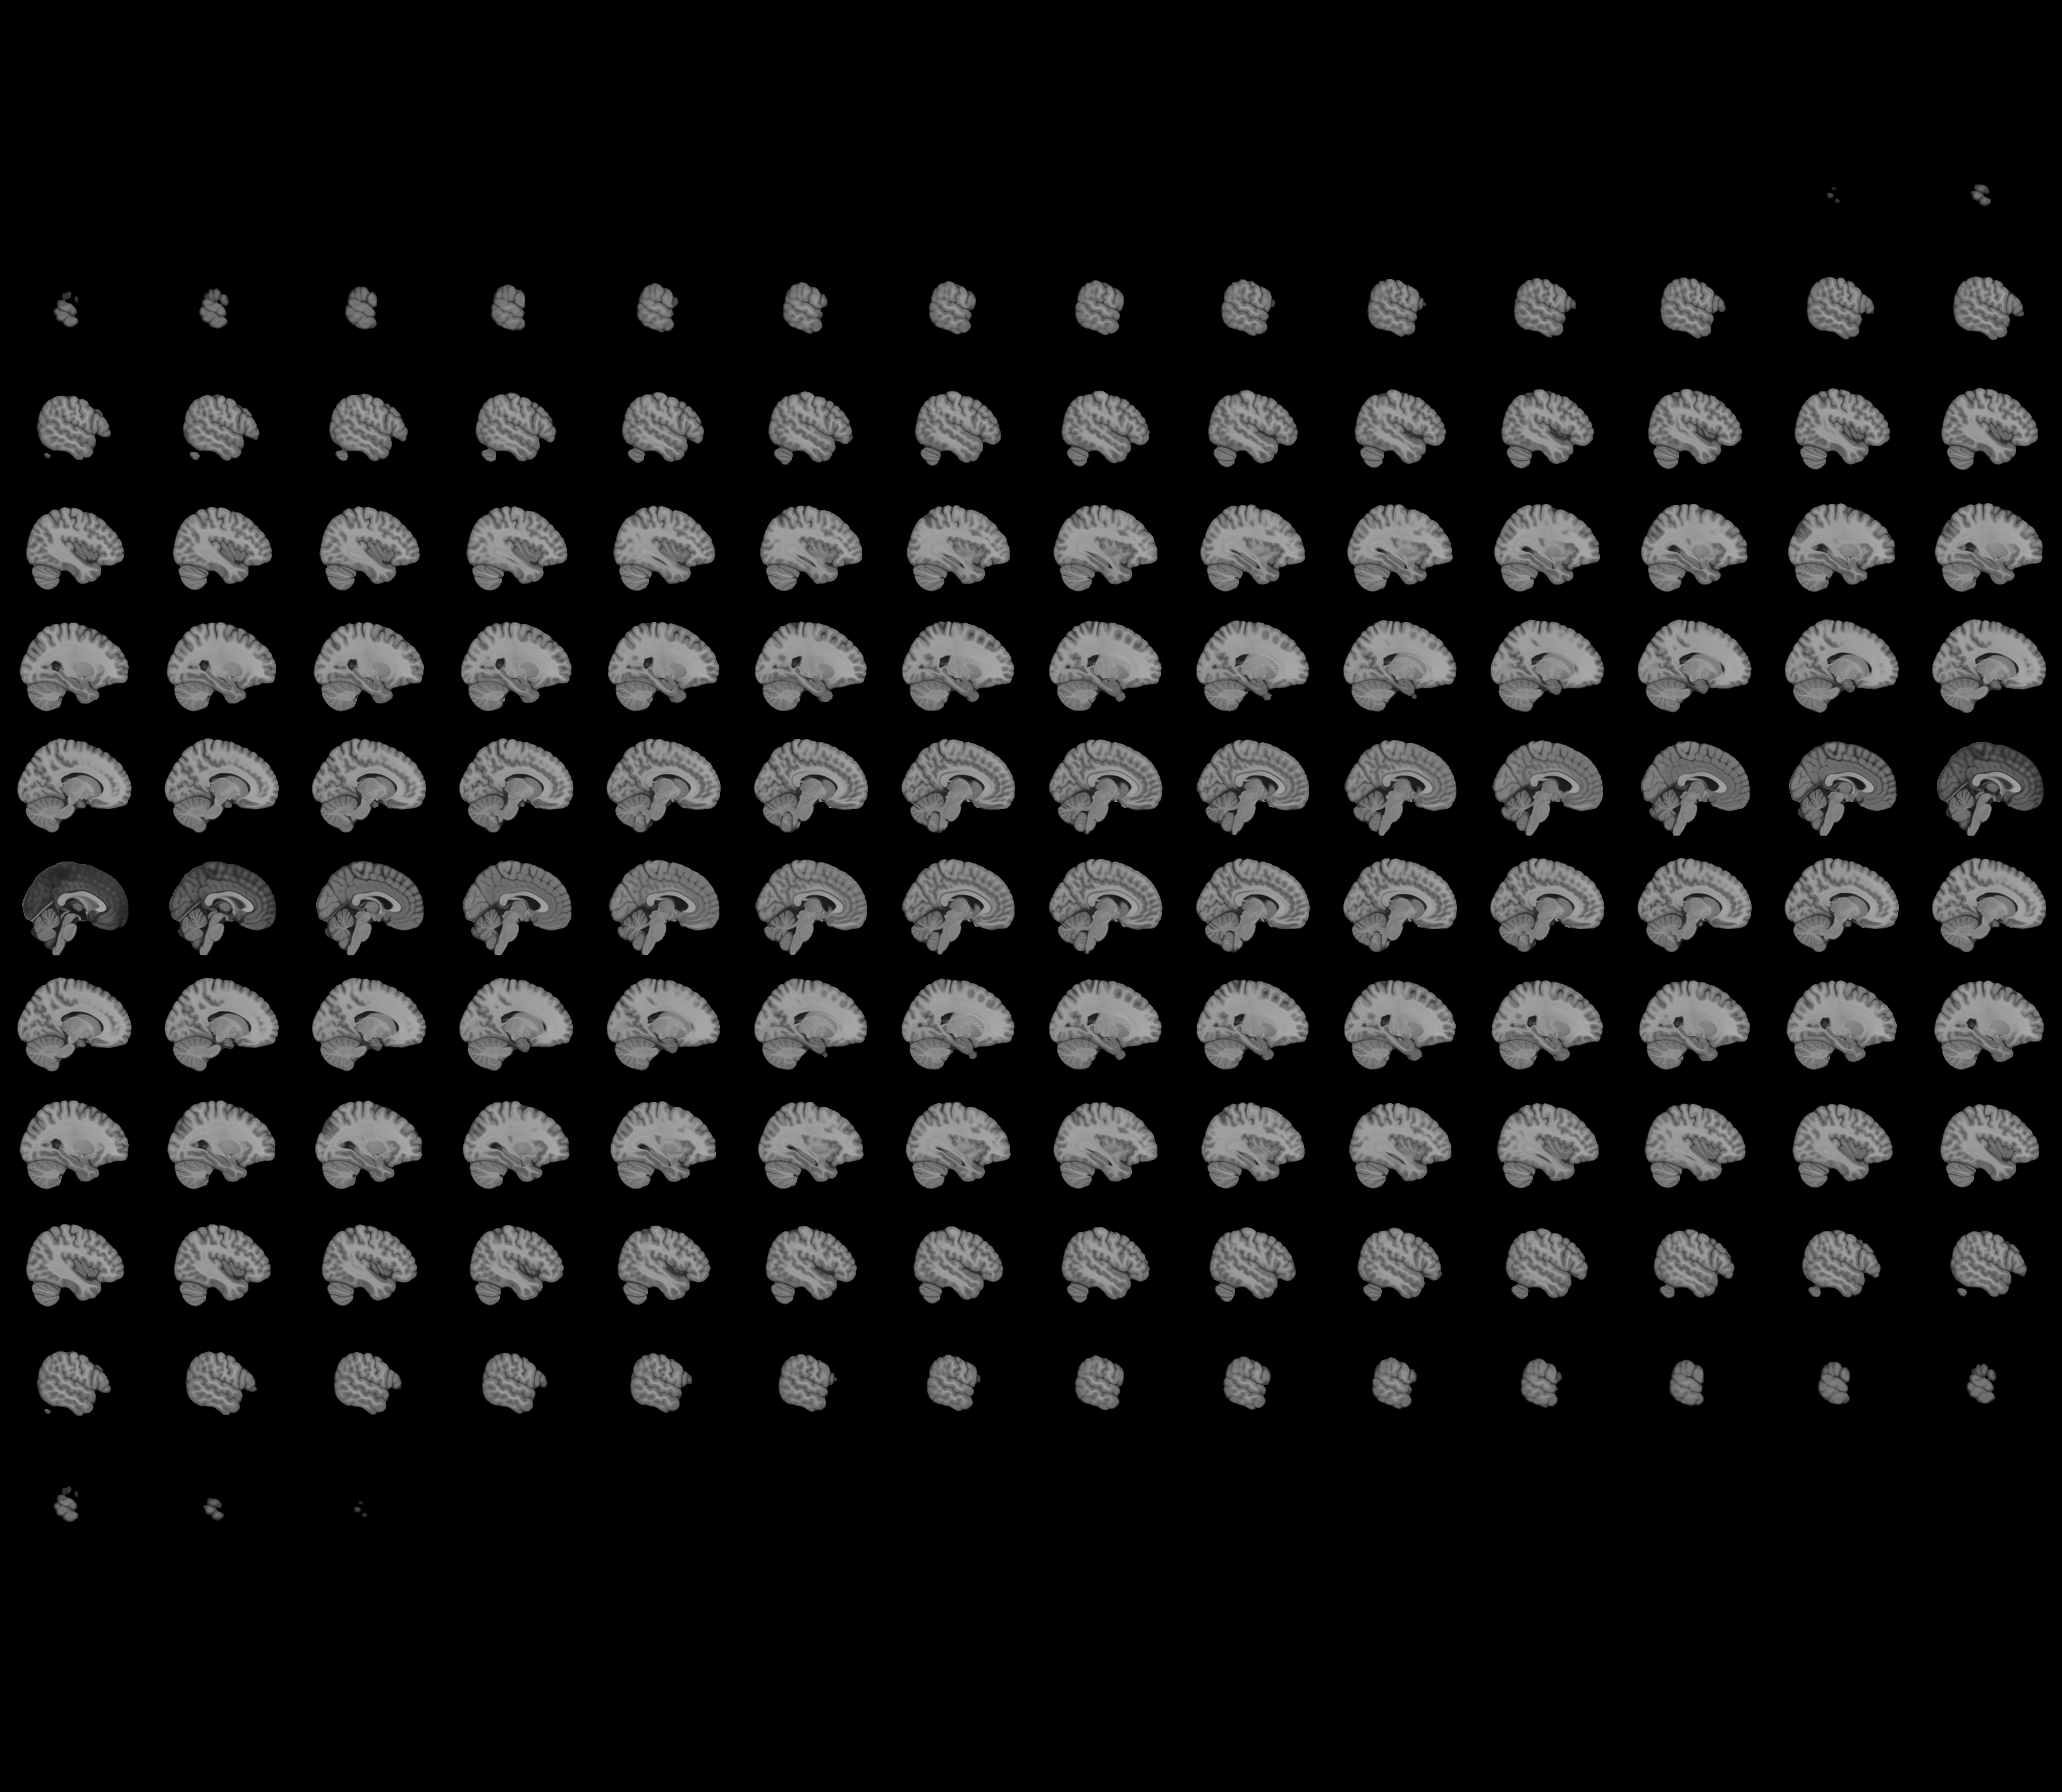
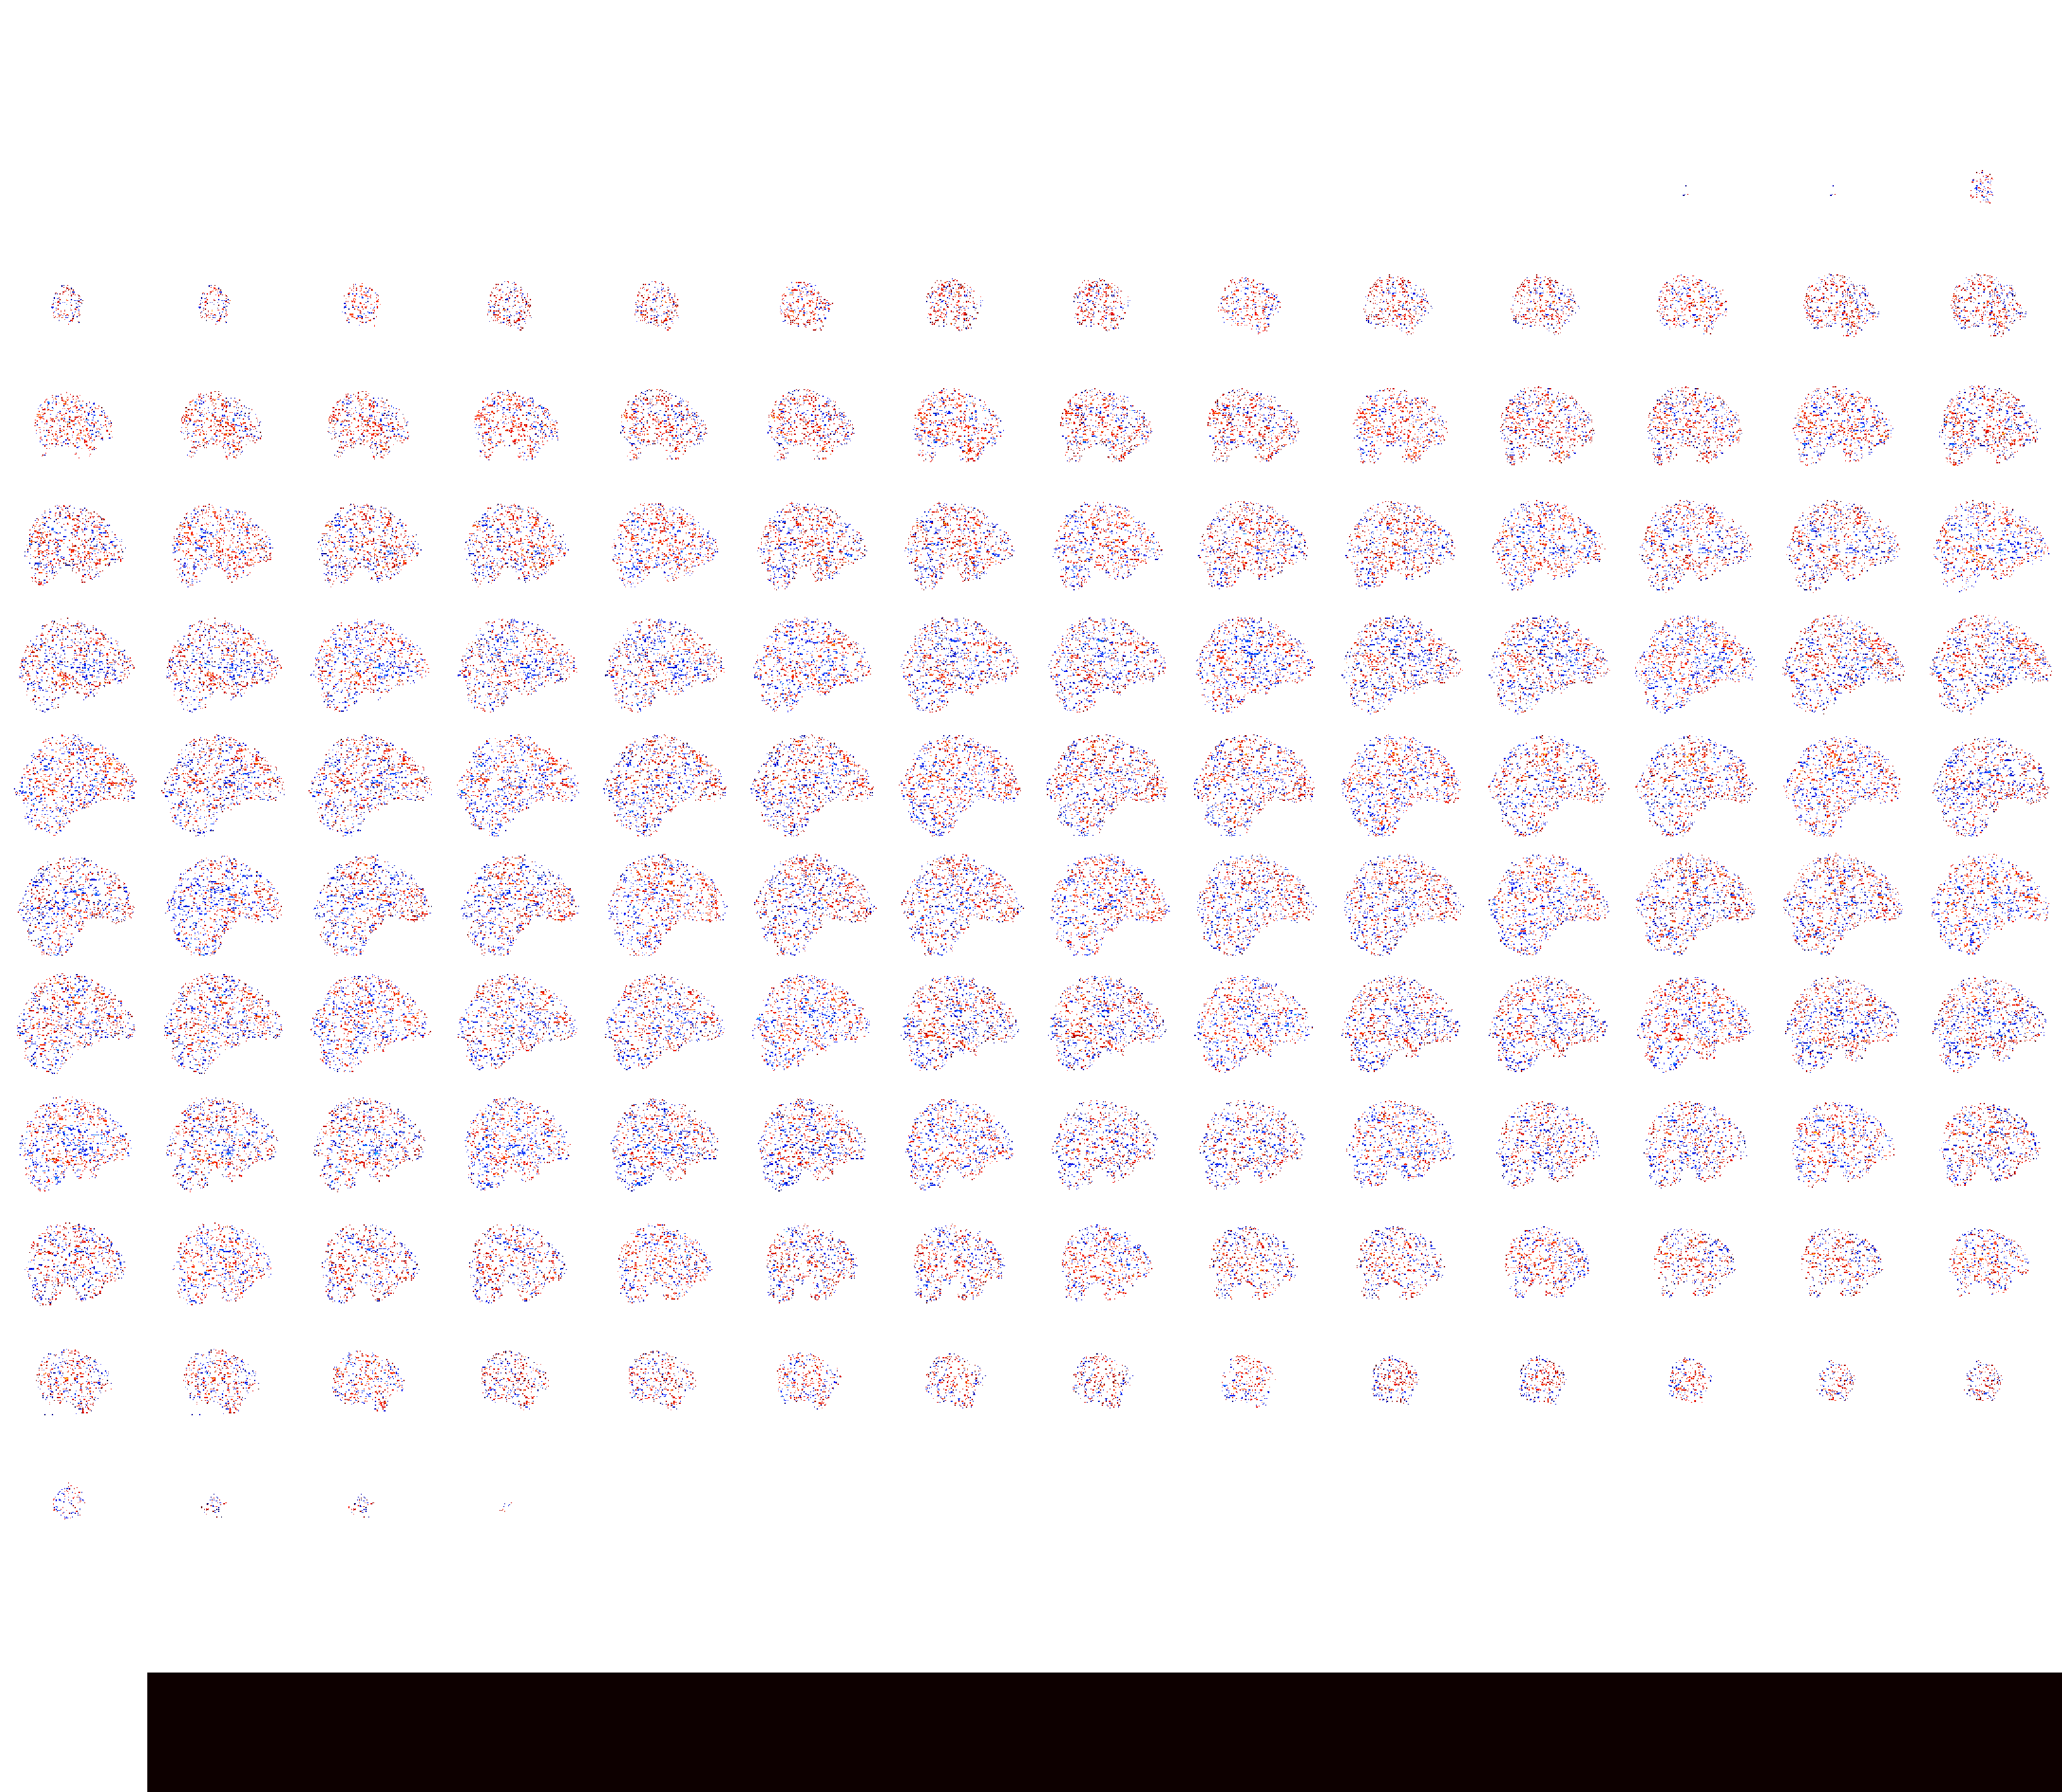

In [18]:
plotting.view_img(z_map, #thresholded_map, 
                  threshold=1.5, #zthresh, 
                  bg_img=mni152_template,
                  cut_coords=[-54, -22, 6],
                  title='Mand early > late sound > baseline')

### Non-Mandarin-speaking group:

#### Get files

In [19]:
fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/*third/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0:2] for sub_id in sub_list_nman]

flat_list_nman = [item for sublist in fnames_nman for item in sublist]
print(flat_list_nman)

['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/grouped_runs/earlythird/sub-FLT02_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/grouped_runs/latethird/sub-FLT02_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/grouped_runs/earlythird/sub-FLT04_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/grouped_runs/latethird/sub-FLT04_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz', '/bgfs/bchandrasekaran/krs228

In [20]:
split_list = [x%2-0.5 for x in range(2*len(sub_list_nman))]
split_df = pd.DataFrame({'split':split_list})

nman_sub_split_dict = {}
for sx, sub in enumerate(sub_list_nman):
    sub_ind_list = np.zeros(2*len(sub_list_nman))
    sub_ind_list[2*sx:2*sx+2] = 1
    
    nman_sub_split_dict[sub] = sub_ind_list
nman_sub_split_dict

nman_sub_split_df = pd.DataFrame(nman_sub_split_dict)

nman_split_df = pd.concat([split_df, nman_sub_split_df], axis=1)

In [21]:
nman_split_df

split  sub-FLT02  sub-FLT04  sub-FLT06  sub-FLT09  sub-FLT11  sub-FLT12  \
0    -0.5        1.0        0.0        0.0        0.0        0.0        0.0   
1     0.5        1.0        0.0        0.0        0.0        0.0        0.0   
2    -0.5        0.0        1.0        0.0        0.0        0.0        0.0   
3     0.5        0.0        1.0        0.0        0.0        0.0        0.0   
4    -0.5        0.0        0.0        1.0        0.0        0.0        0.0   
5     0.5        0.0        0.0        1.0        0.0        0.0        0.0   
6    -0.5        0.0        0.0        0.0        1.0        0.0        0.0   
7     0.5        0.0        0.0        0.0        1.0        0.0        0.0   
8    -0.5        0.0        0.0        0.0        0.0        1.0        0.0   
9     0.5        0.0        0.0        0.0        0.0        1.0        0.0   
10   -0.5        0.0        0.0        0.0        0.0        0.0        1.0   
11    0.5        0.0        0.0        0.0        0.0        0.0        1.0   
12   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
13    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
14   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
15    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
16   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
17    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
18   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
19    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
20   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
21    0.5        0.0        0.0        0.0        0.0        0.0        0.0   
22   -0.5        0.0        0.0        0.0        0.0        0.0        0.0   
23    0.5        0.0        0.0        0.0        0.0        0.0        0.0   

    sub-FLT13  sub-FLT14  sub-FLT20  sub-FLT25  sub-FLT28  sub-FLT30  
0         0.0        0.0        0.0        0.0        0.0        0.0  
1         0.0        0.0        0.0        0.0        0.0        0.0  
2         0.0        0.0        0.0        0.0        0.0        0.0  
3         0.0        0.0        0.0        0.0        0.0        0.0  
4         0.0        0.0        0.0        0.0        0.0        0.0  
5         0.0        0.0        0.0        0.0        0.0        0.0  
6         0.0        0.0        0.0        0.0        0.0        0.0  
7         0.0        0.0        0.0        0.0        0.0        0.0  
8         0.0        0.0        0.0        0.0        0.0        0.0  
9         0.0        0.0        0.0        0.0        0.0        0.0  
10        0.0        0.0        0.0        0.0        0.0        0.0  
11        0.0        0.0        0.0        0.0        0.0        0.0  
12        1.0        0.0        0.0        0.0        0.0        0.0  
13        1.0        0.0        0.0        0.0        0.0        0.0  
14        0.0        1.0        0.0        0.0        0.0        0.0  
15        0.0        1.0        0.0        0.0        0.0        0.0  
16        0.0        0.0        1.0        0.0        0.0        0.0  
17        0.0        0.0        1.0        0.0        0.0        0.0  
18        0.0        0.0        0.0        1.0        0.0        0.0  
19        0.0        0.0        0.0        1.0        0.0        0.0  
20        0.0        0.0        0.0        0.0        1.0        0.0  
21        0.0        0.0        0.0        0.0        1.0        0.0  
22        0.0        0.0        0.0        0.0        0.0        1.0  
23        0.0        0.0        0.0        0.0        0.0        1.0

#### Using combined GLM, with contrast isolating Mandarin group

In [22]:
contrast_array = np.concatenate([[1,], np.zeros(len(sub_list_nman))])
print(contrast_array)           

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
# create a model object
second_level_model = SecondLevelModel().fit(flat_list_nman, design_matrix=nman_split_df)

# fit the model with our contrast of interest
z_map = second_level_model.compute_contrast(second_level_contrast=contrast_array, output_type='z_score')

In [24]:
# threshold the second-level stats image
alpha = 0.05
cthresh = 10
cluster_correct = None #'fdr'

thresholded_map, zthresh = threshold_stats_img(
                            z_map,
                            alpha=alpha,
                            height_control=cluster_correct,
                            cluster_threshold=cthresh,
                            two_sided=True,
                        )

In [25]:
plot_title = ('Non-Mandarin-speaking group (n=%d)\n'
              'early vs. late \n'
              '%s > baseline FDR-corrected z map \n'
              'p < %.02f, clusters > %d voxels'%(len(sub_list_nman), contrast_label, alpha, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


The None=0.05 threshold is 3


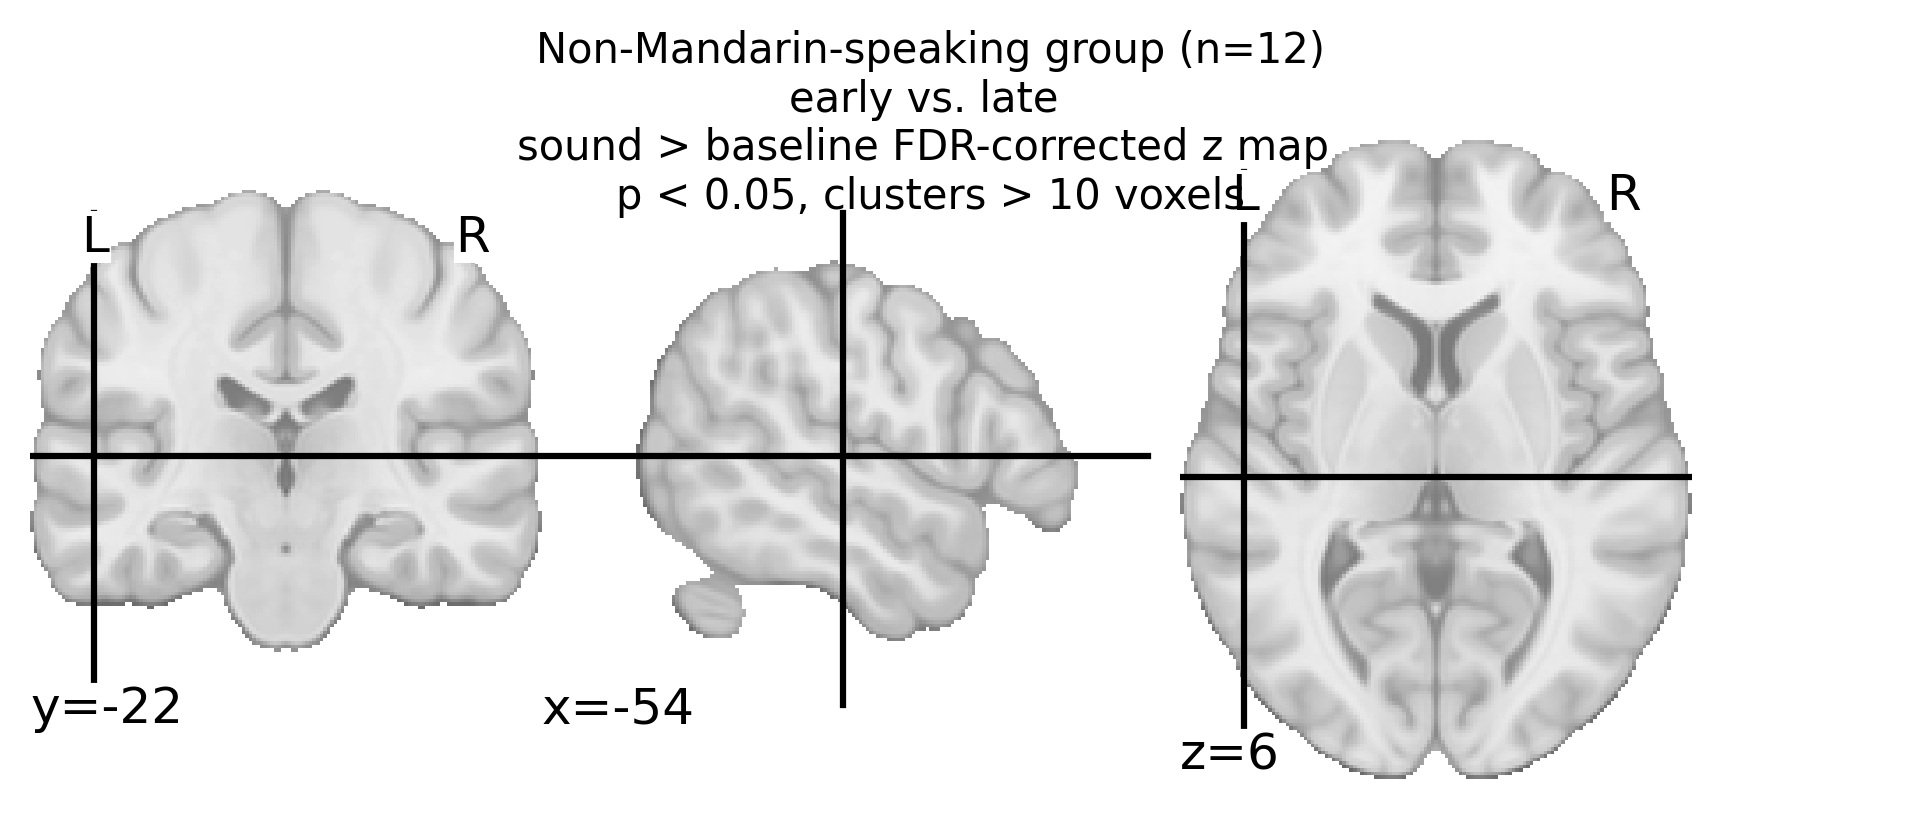

In [26]:
fig, ax = plt.subplots(figsize=(8,3), dpi=300)

plotting.plot_stat_map(
    thresholded_map, 
    threshold=zthresh,
    bg_img=mni152_template,
    black_bg=False,
    cut_coords=[-54, -22, 6],
    #display_mode='mosaic',
    #title=plot_title,
    axes=ax)
fig.suptitle(plot_title, fontsize=10);
print('The %s=%.3g threshold is %.3g' %(cluster_correct, alpha, zthresh))
#fig.savefig(os.path.join(group_out_dir,
#                     'group-Mand_space-{}_contrast-{}_view-ortho.png'.format(space_label, contrast_label)))

Interactive viewer:

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



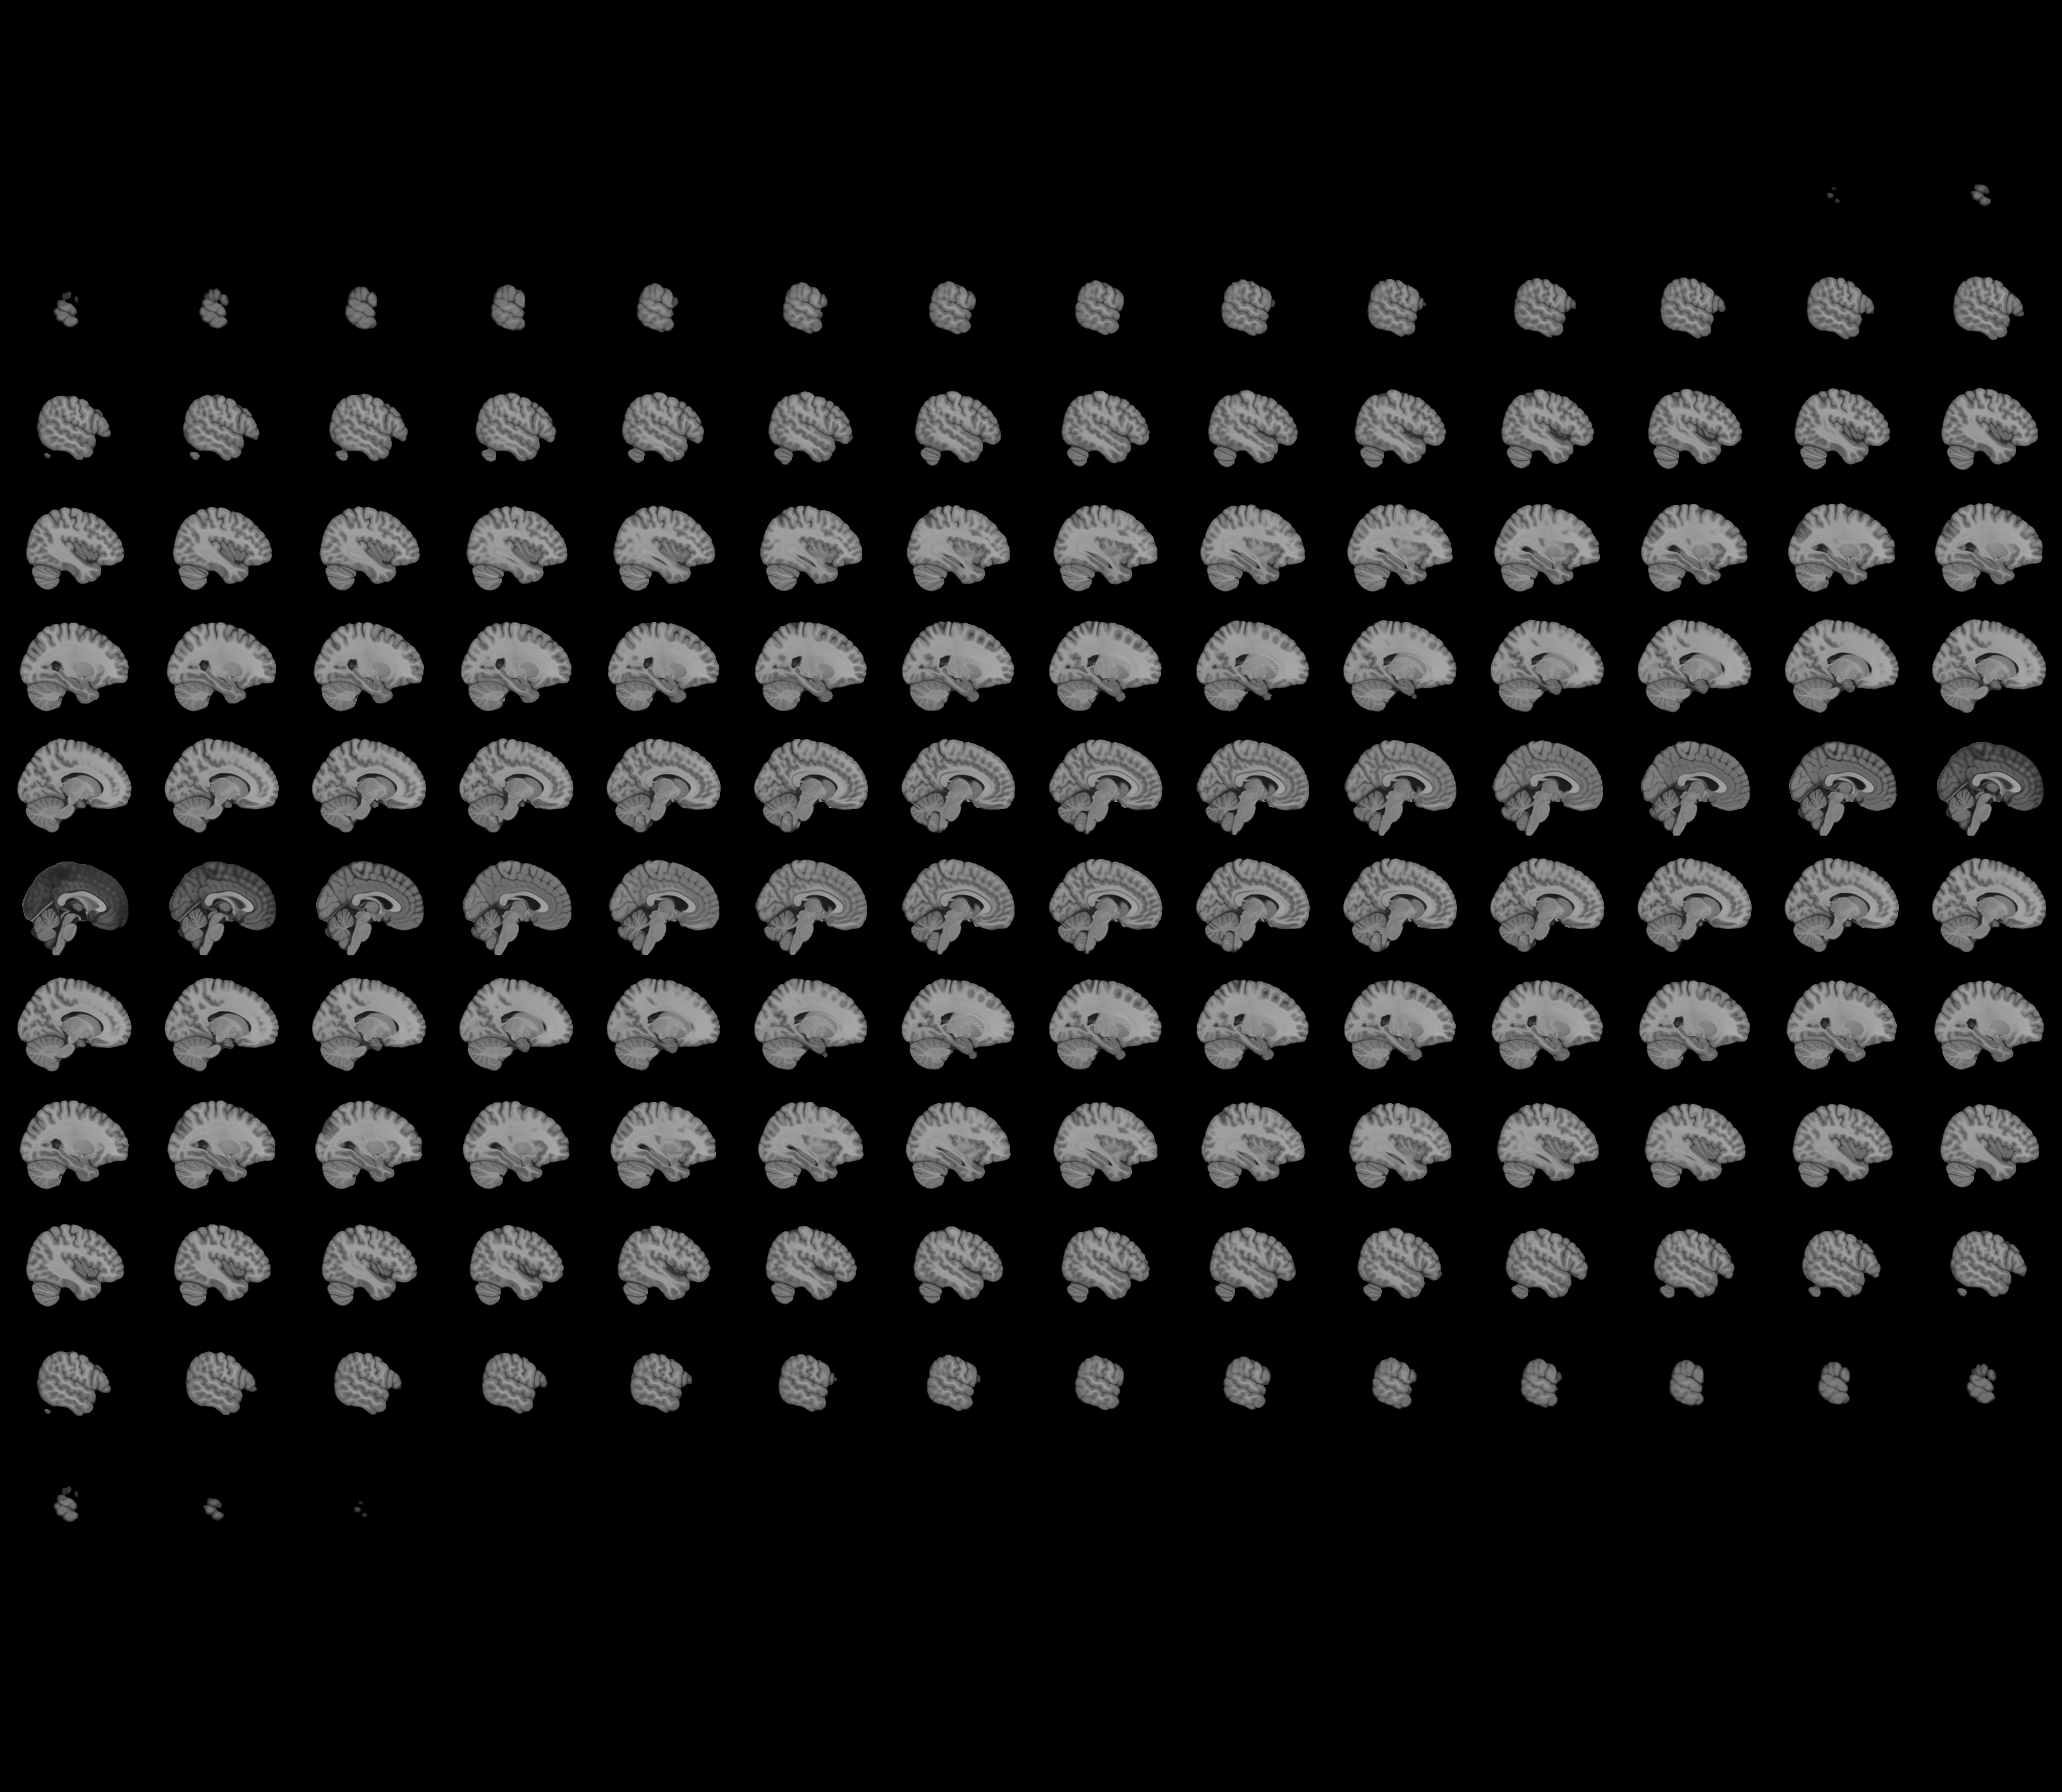
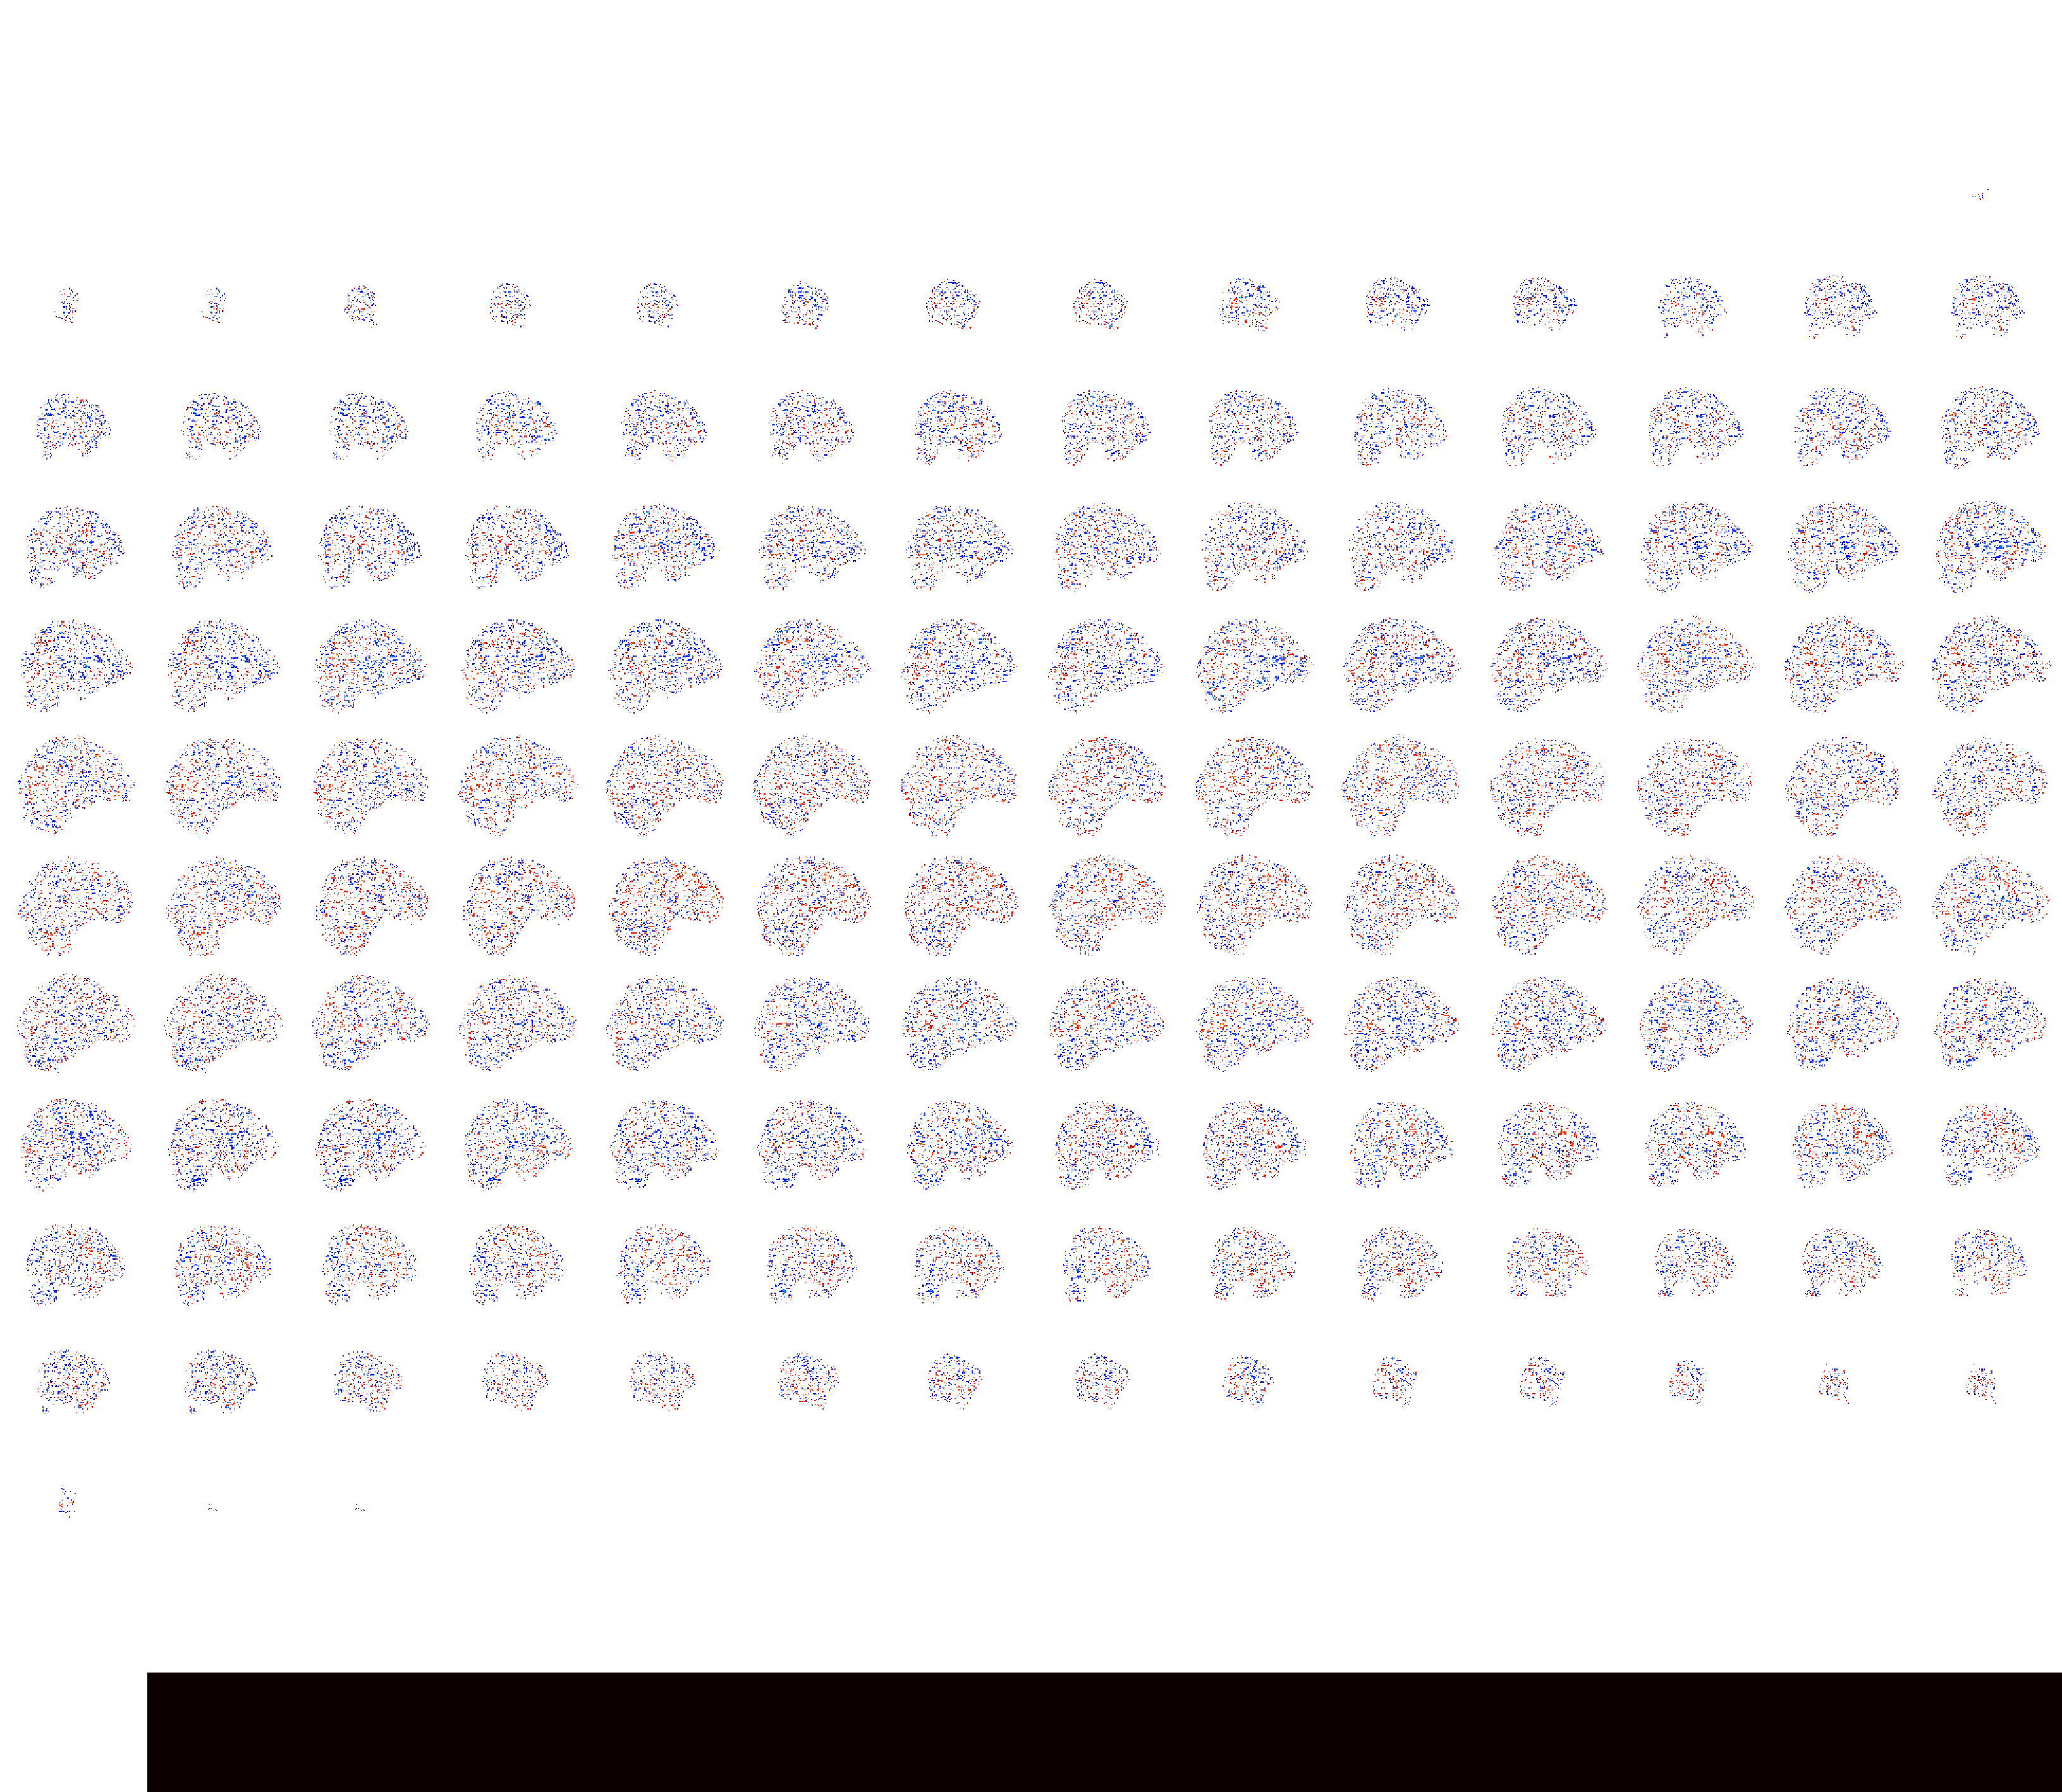

In [27]:
plotting.view_img(z_map, #thresholded_map, 
                  threshold=1.5, #zthresh, 
                  bg_img=mni152_template,
                  cut_coords=[-54, -22, 6],
                  title='Mand early > late sound > baseline')